In [1]:
%matplotlib inline
# install SNN-Toolbox
!pip install git+https://github.com/NeuromorphicProcessorProject/snn_toolbox.git#egg=snntoolbox
#install brian2
# !pip install brian2
# install nengo and nengo-dl
!pip install nengo nengo-dl[docs]

In [2]:
# import standard modules
import sys, os, time

# import useful modules
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import Keras layers, Model and mnist dataset
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import (
    Dense, Dropout, Flatten, Conv2D, Input, BatchNormalization, Activation,
    Concatenate, AveragePooling2D
  )

# import Google Drive module
from google.colab import drive

# import SNN-Toolbox functions
from snntoolbox.bin.run import main
from snntoolbox.utils.utils import import_configparser

# import Nengo-DL modules
import nengo, nengo_dl

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/nengo_dl/converter.py:360: UserWarning: Layer '<class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>' already has a converter. Overwriting.
  "Layer '%s' already has a converter. Overwriting." % keras_layer


In [3]:
# mount google drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [4]:
# set random generators for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

# create dirs for result files
cwd = os.path.realpath('.')
path_wd = os.path.abspath(
    os.path.join(os.path.realpath('.'), 'temp', 'mnist', str(time.time())
      )
  )
print('Output path: {}\nCurrent working directory: {}'.format(path_wd, cwd))
os.makedirs(path_wd)

Output path: /content/drive/My Drive/temp/mnist/1588130935.0752583
Current working directory: /content/drive/My Drive


In [0]:
# load dataset
dataset = mnist.load_data()

In [0]:
# preprocess data
def preprocess(data):
  assert data is not None
  (x_train, y_train), (x_test, y_test) = data
  # reshape dataset to have a single channel
  x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
  x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
  # convert from integers to floats
  train_norm = x_train.astype('float32')
  test_norm = x_test.astype('float32')
  # normalize to range 0-1
  x_train = train_norm / 255.0
  x_test = test_norm / 255.0
  # one hot encode target values
  y_train = keras.utils.np_utils.to_categorical(y_train)
  y_test = keras.utils.np_utils.to_categorical(y_test)

  return x_train, y_train, x_test, y_test

In [7]:
## TRAIN KERAS MODEL ##

# initial parameters
batch_size = 1024
epochs = 2

# define cnn model
model = Sequential((
    Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        kernel_initializer='he_uniform',
        name='conv1',
        input_shape=(28, 28, 1)
    ),
    AveragePooling2D(),
    Conv2D(
        filters=64,
        kernel_size=3,
        strides=2,
        activation='relu',
        kernel_initializer='he_uniform',
        name='conv2'
    ),
    Flatten(),
    Dense(100, activation='relu', kernel_initializer='he_uniform'),
    Dense(units=10, name='dense10'),
    Activation(activation='softmax', name='out_layer')
))
model.summary()

loss_fn = 'categorical_crossentropy'
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               230500    
_________________________________________________________________
dense10 (Dense)              (None, 10)                1010      
_________________________________________________________________
out_layer (Activation)       (None, 10)               

In [8]:
# train and evaluate Keras ANN
x_train, y_train, x_test, y_test = preprocess(dataset)
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(x_test, y_test)
    )
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save trained model
model_name = 'keras_model'
model_path = os.path.join(path_wd, model_name + '.h5')
keras.models.save_model(
    model, model_path
  )
np.savez_compressed(os.path.join(path_wd, 'x_test'), x_test)
np.savez_compressed(os.path.join(path_wd, 'y_test'), y_test)
np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

print('Model and dataset saved to {}'.format(model_path))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
 - 12s - loss: 0.4862 - accuracy: 0.8643 - val_loss: 0.1616 - val_accuracy: 0.9516
Epoch 2/2
 - 12s - loss: 0.1216 - accuracy: 0.9651 - val_loss: 0.0810 - val_accuracy: 0.9763
Test loss: 0.0810183768529445
Test accuracy: 0.9763000011444092
Model and dataset saved to /content/drive/My Drive/temp/mnist/1588130935.0752583/keras_model.h5


Initializing INI simulator...

Loading data set from '.npz' files in /content/drive/My Drive/temp/mnist/1588130935.0752583.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               230500    
_________________________________________________________________
dense10 (Dense)              (None, 10)                1010  

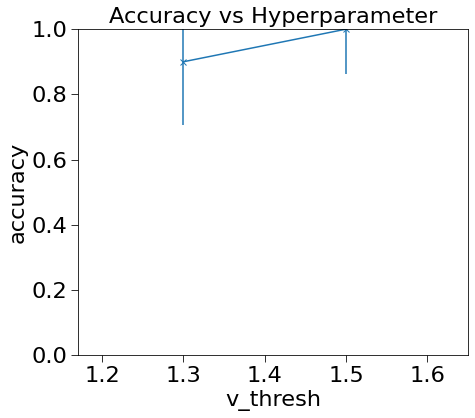

In [9]:
## CONFIGURE SNN-TOOLBOX

# path_wd = '/content/drive/My Drive/GitHub/MNIST_usecase/temp/1586517276.4758515'

# Create configuration for SNN-Toolbox and execute the simulation.
assert path_wd is not None

# initial parameters
dt = 0.1  # Time resolution of simulator.
snn_sim = 'INI'
timesteps = 30
n_samples = 10
sim_batch = 5
plots = {} 
""" 
{'spiketrains', 'spikerates', 'activations', 'correlation', 'v_mem', 'error_t'}
"""

# Create a config file with experimental setup for SNN Toolbox.
configparser = import_configparser()
config = configparser.ConfigParser()

config['paths'] = {
    'path_wd': path_wd,  # Path to model.
    'dataset_path': path_wd,  # Path to dataset.
    'filename_ann': model_name  # Name of input model.
}

config['tools'] = {
    'evaluate_ann': True,  # Test ANN on dataset before conversion.
    'normalize': True,  # Normalize weights for full dynamic range.
}

config['simulation'] = {
    'simulator': snn_sim,
    'duration': timesteps,
    'num_to_test': n_samples,
    'batch_size': sim_batch,
    'dt': dt
}

config['cell'] = {
    # 'v_thresh': 0.01,  # Reducing default value (1) for higher spikerates.
    'tau_refrac': dt,  # Refractory period and delay must be at
    'delay': dt  # least one time step.
}

config['parameter_sweep'] = {
    'param_name': 'v_thresh',
    'param_values': [1.3, 1.5]
}

"""
    Various plots (slows down simulation).
    Leave section empty to turn off plots.
"""
config['output'] = {
    'plot_vars': plots
}

# Store config file.
config_filepath = os.path.join(path_wd, 'config')
with open(config_filepath, 'w') as configfile:
    config.write(configfile)

# RUN SNN TOOLBOX #
###################

main(config_filepath)


In [30]:
# initial parameters
model_params = os.path.join(path_wd, 'keras_to_snn_regularized_params')

# reload model in tensorflow.keras and pop unsupported Softmax layer
model = tf.keras.models.load_model(model_path)
# model.pop()
loss_fn = 'categorical_crossentropy'
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               230500    
_________________________________________________________________
dense10 (Dense)              (None, 10)                1010      
_________________________________________________________________
out_layer (Activation)       (None, 10)               

In [31]:
# convert keras model to nengo network
converter = nengo_dl.Converter(model)

# flatten and add time dimension to data
x_train = x_train.reshape(x_train.shape[0], 1, -1)
x_test = x_test.reshape(x_test.shape[0], 1, -1)
y_train = y_train.reshape(y_train.shape[0], 1, -1)
y_test = y_test.reshape(y_test.shape[0], 1, -1)

# add probes to the convolutional layers, which
# we'll use to apply the firing rate regularization
with converter.net:
    output_p = converter.outputs[converter.model.output]

with nengo_dl.Simulator(converter.net, minibatch_size=sim_batch) as sim:
    # add regularization loss functions to the convolutional layers
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss={
            output_p: tf.losses.CategoricalCrossentropy(from_logits=True)
        },
        loss_weights={output_p: 1}
    )

    do_training = True #os.path.isfile(model_params)
    if do_training:
      # run training (specifying the target rates for the convolutional layers)
      sim.fit(
          {converter.inputs[converter.model.input]: x_train}, 
          {output_p: y_train},
          epochs=epochs
        )

      # save the parameters to file
      sim.save_params(model_params)
    else:
      # load saved params from file
      sim.load_params(model_params)
      print('params loaded from file')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#                        Constructing graph                          | 0:00:00

/usr/local/lib/python3.6/dist-packages/nengo_dl/converter.py:555: UserWarning: Activation type <function softmax at 0x7fb9d11207b8> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation
/usr/local/lib/python3.6/dist-packages/nengo_dl/converter.py:139: UserWarning: Converting sequential model to functional model
  warnings.warn("Converting sequential model to functional model")
/usr/local/lib/python3.6/dist-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Construction finished in 0:00:00                                               
Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 274s 5ms/sample - loss: 1.5025 - probe_loss: 1.5024
Epoch 2/2
60000/60000 [==============================] - 284s 5ms/sample - loss: 1.4892 - probe_loss: 1.4891


In [0]:
def run_network(activation, params_file="keras_to_snn_params", n_steps=timesteps,
                scale_firing_rates=1, synapse=None, n_test=n_samples):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )
    
    # get input/output objects
    nengo_input = nengo_converter.inputs[nengo_converter.model.input]
    nengo_output = nengo_converter.outputs[nengo_converter.model.output]
    
    # add a probe to the first convolutional layer to record activity
    with nengo_converter.net:
        conv0_probe = nengo.Probe(
            nengo_converter.layers[model.layers[0].get_output_at(-1)])        
        dense10_output = nengo.Probe(
            nengo_converter.layers[model.layers[-1].get_output_at(-1)]
        )

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(x_test[:n_test], (1, n_steps, 1))
    
    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)
            
    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
            nengo_converter.net, minibatch_size=10, 
            progress_bar=False) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    y_true = np.argmax(y_test[:, -1], axis=-1)[:n_test]
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    pred_dense10 = np.argmax(data[dense10_output][:, -1], axis=-1)
    print('y_true({}): {}'.format(y_true.shape,y_true))
    print('predictions({}): {}'.format(predictions.shape, predictions))
    print('dense layer predictions({}): {}'.format(
        pred_dense10.shape, pred_dense10))
    accuracy = (predictions == y_true).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    # plot the results
    for ii in range(4):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(x_test[ii, 0].reshape((28, 28)), cmap="gray")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        sample_neurons = np.linspace(
            0,
            data[conv0_probe].shape[-1], 
            1000,
            endpoint=False,
            dtype=np.int32,
        )
        scaled_data = data[conv0_probe][ii, :, sample_neurons].T * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel('Number of spikes')
        else:
            rates = scaled_data
            plt.ylabel('Firing rates (Hz)')
        plt.xlabel('Timestep')
        plt.title(
            "Neural activities (conv0 mean=%dHz max=%dHz)" % (
                rates.mean(), rates.max())
        )
        plt.plot(scaled_data)
        
        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel('Timestep')
        plt.ylabel("Probability")
            
        plt.tight_layout()

In [35]:
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file=os.path.join(path_wd, 'keras_to_snn_regularized_params'),
    synapse=0.01,
)

/usr/local/lib/python3.6/dist-packages/nengo_dl/converter.py:555: UserWarning: Activation type <function softmax at 0x7fb9d11207b8> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation
/usr/local/lib/python3.6/dist-packages/nengo_dl/converter.py:139: UserWarning: Converting sequential model to functional model
  warnings.warn("Converting sequential model to functional model")
/usr/local/lib/python3.6/dist-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


SimulationError: ignored

In [0]:
# plot the keras model
# path_wd = '/content/drive/My Drive/GitHub/MNIST_usecase/temp/1586608076.7395697'

from os.path import join
from keras.models import load_model
# path_wd = '/content/drive/My Drive/GitHub/MNIST_usecase/temp/1586608076.7395697'
model = load_model(join(path_wd, 'keras_model.h5'))
from IPython.display import SVG
from keras.utils import model_to_dot

model_to_dot(model, show_shapes=True, rankdir='TB', dpi=96).write_svg('keras_model.svg')